In [2]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from numpy import arange
from numpy import meshgrid
import numpy as np
from scipy.optimize import linprog

In [3]:
def calc_parab_ineq(m_bounds, m_ind: int, p_ind: int, vector_size: int):
    """Calculate halfplane inequalities (bounding p) for p=m**2"""
    g = m_bounds[0]
    h = m_bounds[1]
    g2 = g**2
    h2 = h**2
    A_ub = np.zeros((3,vector_size))
    A_ub[0,m_ind] = g2-h2#g**2-h**2 #np.square(g)-np.square(h)
    A_ub[0,p_ind] = h-g
    A_ub[1,m_ind] = 2*g
    A_ub[1,p_ind] = -1
    A_ub[2,m_ind] = 2*h
    A_ub[2,p_ind] = -1

    b_ub = np.array([g2*(h-g)-g*(h2-g2), g2, h2])
    # b_ub = np.array([g**2*(h-g)-g*(h**2-g**2), g**2, h**2])
    # b_ub = np.array([np.square(g)*(h-g)-g*(np.square(h)-np.square(g)), np.square(g), np.square(h)])
    return A_ub, b_ub

def pow_interval(interval, p: int):
    is_odd = p%2>0
    if is_odd:
        return (interval[0]**p, interval[1]**p)
    else:
        is_zerocross = interval[0]*interval[1]<=0
        return np.asarray((0 if is_zerocross else np.min(abs(interval))**p, np.max(abs(interval))**p))

def mul_intervals(interval1, interval2):
    a1,a2 = interval1[0], interval1[1]
    b1,b2 = interval2[0], interval2[1]
    return np.asarray((np.min([a1*b1,a1*b2,a2*b1,a2*b2]), np.max([a1*b1,a1*b2,a2*b1,a2*b2])))

def subtr_intervals(interval1, interval2):
    a1,a2 = interval1[0], interval1[1]
    b1,b2 = interval2[0], interval2[1]
    return np.asarray((a1-b2,a2-b1))

def neg_interval(interval):
    return np.asarray((-interval[1],-interval[0]))

In [4]:
def calc_plane_coeffs(p1,p2,p3):
    x1,y1,z1 = p1[0],p1[1],p1[2]
    x2,y2,z2 = p2[0],p2[1],p2[2]
    x3,y3,z3 = p3[0],p3[1],p3[2]

    A = y1*(z2 - z3) + y2*(z3 - z1) + y3*(z1 - z2)
    B = z1*(x2 - x3) + z2*(x3 - x1) + z3*(x1 - x2)
    C = x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2)
    Dn = x1*(y2*z3 - y3*z2) + x2*(y3*z1 - y1*z3) + x3*(y1*z2 - y2*z1)
    return np.array([A,B,C,Dn])

def calc_hyberb_ineq(m_bounds, n_bounds, m_ind: int, n_ind: int, p_ind: int, vector_size: int):
    """Calculate halfspace inequalities (bounding p) for p=m*n"""
    gm = m_bounds[0]
    hm = m_bounds[1]
    gn = n_bounds[0]
    hn = n_bounds[1]

    p1 = (gm,gn,gm*gn)
    p2 = (gm,hn,gm*hn)
    p3 = (hm,hn,hm*hn)
    p4 = (hm,gn,hm*gn)
    # print(p1,p2,p3,p4)

    pl1 = calc_plane_coeffs(p1,p2,p3) #< Dn
    pl2 = calc_plane_coeffs(p1,p3,p4) #< Dn
    pl3 = calc_plane_coeffs(p1,p2,p4) #> 
    pl4 = calc_plane_coeffs(p2,p3,p4) #> 
    # print(pl1,pl2,pl3,pl4)
    
    A_ub = np.zeros((4,vector_size))
    A_ub[0,[m_ind, n_ind, p_ind]] = -pl1[:3]
    A_ub[1,[m_ind, n_ind, p_ind]] = -pl2[:3]
    A_ub[2,[m_ind, n_ind, p_ind]] = pl3[:3]
    A_ub[3,[m_ind, n_ind, p_ind]] = pl4[:3]

    b_ub = np.asarray([-pl1[3], -pl2[3], pl3[3], pl4[3]])
    return A_ub, b_ub

In [19]:
#TODO fix overlapping boxes issue, not critical
def approximate_boxes(B, A_eq, b_eq, sqr_pairs=[], cross_triplets=[], threshold_s=[0.1], threshold_v=0.95):
    n = np.shape(B)[0]
    is_sigma_simple = len(threshold_s) == 1

    # print(B)
    # A_ub = np.zeros((3*len(sqr_pairs), n))
    # b_ub = np.zeros(3*len(sqr_pairs))
    A_ub = np.full((3*len(sqr_pairs)+4*len(cross_triplets), n),None)
    b_ub = np.full(3*len(sqr_pairs)+4*len(cross_triplets),None)

    # Blist = [(B[i,0],B[i,1]) for i in range(n)]
    # print(Blist)
    # c = np.zeros(n)
    # c[0] = 1
    # minim = linprog(c,A_eq=A_eq,b_eq=b_eq,bounds=B)
    # print(minim.fun)
    # print(f'suc{minim.success}, stat{minim.status}, nit{minim.nit}\nmsg: {minim.message}')

    # minim = linprog(-c,A_eq=A_eq,b_eq=b_eq,bounds=B)
    # print(-minim.fun)
    # print(f'suc{minim.success}, stat{minim.status}, nit{minim.nit}\nmsg: {minim.message}')

    sols = []
    P = [B]
    while len(P) > 0:
        print(f'lenP {len(P)}')
        B_c = P.pop() #0

        lengths_c = B_c[:,1] - B_c[:,0]
        # valid_inds = (lengths_c > 0).nonzero()
        # print('valind',valid_inds)
        # print('valleng',lengths_c[valid_inds])
        
        is_empty = False
        is_shrinkable = True
        if is_sigma_simple:
            is_small_enough = np.max(lengths_c) <= threshold_s[0]
        else:
            is_small_enough = (lengths_c <= threshold_s).all()
        
        while not is_empty and is_shrinkable and not is_small_enough:  #uncomment for better timings
            lengths_p = lengths_c
            # valid_inds_p = np.transpose((lengths_p > 0).nonzero())
            valid_inds_p = (lengths_p > 0).nonzero()[0]

            #shrink
            for i in valid_inds_p: #range(n):
                c = np.zeros(n)
                c[i] = 1

                #inequalities for current bounds
                shift = 0
                for j, (m_ind, p_ind) in enumerate(sqr_pairs):
                    A, b = calc_parab_ineq(B_c[m_ind,:], m_ind, p_ind, n)
                    A_ub[3*j:3*j+3,:] = A
                    b_ub[3*j:3*j+3] = b
                    shift += 3
                for j, (m_ind, n_ind, p_ind) in enumerate(cross_triplets):
                    A, b = calc_hyberb_ineq(B_c[m_ind,:], B_c[n_ind,:], m_ind, n_ind, p_ind, n)
                    A_ub[4*j+shift:4*j+4+shift,:] = A
                    b_ub[4*j+shift:4*j+4+shift] = b

                minim = linprog(c,A_eq=A_eq,b_eq=b_eq,bounds=B_c, A_ub=A_ub, b_ub=b_ub,options={'presolve':False}) #method='highs-ipm' #slower but more boxes with presolve 
                if not minim.success:
                    is_empty = True
                    print(minim.message)
                    # if minim.status != 2:
                    #     print(minim.message)
                    break

                B_c[i,0] = minim.fun

                #comment for better timings
                #inequalities for updated bounds
                shift = 0
                for j, (m_ind, p_ind) in enumerate(sqr_pairs):
                    A, b = calc_parab_ineq(B_c[m_ind,:], m_ind, p_ind, n)
                    A_ub[3*j:3*j+3,:] = A
                    b_ub[3*j:3*j+3] = b
                    shift += 3
                for j, (m_ind, n_ind, p_ind) in enumerate(cross_triplets):
                    A, b = calc_hyberb_ineq(B_c[m_ind,:], B_c[n_ind,:], m_ind, n_ind, p_ind, n)
                    A_ub[4*j+shift:4*j+4+shift,:] = A
                    b_ub[4*j+shift:4*j+4+shift] = b

                maxim = linprog(-c,A_eq=A_eq,b_eq=b_eq,bounds=B_c, A_ub=A_ub, b_ub=b_ub,options={'presolve':False}) #method='highs-ipm'
                if not maxim.success:
                    is_empty = True
                    print(maxim.message)
                    # if maxim.status != 2:
                    #     print(maxim.message)
                    break

                # B_c[i,0] = minim.fun
                B_c[i,1] = -maxim.fun

                # if is_small_enough: #worse than without checking, but better time
                #     break

            lengths_c = B_c[:,1] - B_c[:,0]
            longest_dim_ind = np.argmax(lengths_c)
            if is_sigma_simple:
                is_small_enough = lengths_c[longest_dim_ind] <= threshold_s[0]
            else:
                is_small_enough = (lengths_c <= threshold_s).all()

            valid_inds = (lengths_c > 0).nonzero()
            print('valid indexes',valid_inds[0])
            # print('valleng',lengths_c[valid_inds])
            V_p = np.prod(lengths_p[valid_inds])
            V_c = np.prod(lengths_c[valid_inds])
            
            # print(V_c,V_p)
            is_shrinkable = V_c/V_p <= threshold_v
            # print(is_shrinkable)

        if not is_empty:
            if is_small_enough:
                sols.append(B_c)
            else:
                #split
                half_length = lengths_c[longest_dim_ind]/2.
                B1 = B_c.copy()
                B1[longest_dim_ind,1] -= half_length
                B2 = B_c.copy()
                B2[longest_dim_ind,0] += half_length
                P.append(B1)
                P.append(B2)
    return sols

In [7]:
# y4=y2-x2
# x2 = x**2
# y2 = y**2
# y4 = y2**2

# x2-y2+y4=0
# X = [x,y,x2,y2,y4]

xb = np.array([-0.75,0.75])
yb = np.array([-1.25,1.25])
# xb = np.array([-.2,.2])
# yb = np.array([-.2,.2])

B = np.asarray([xb,yb,pow_interval(xb,2),pow_interval(yb,2),pow_interval(yb,4)])

A_eq = np.array([[0,0,1,-1,1]]) #колво равенств
b_eq = np.array([0]) # правые части равенств

sqr_pairs = [(0,2), (1,3), (3,4)]
cross_triplets = []


threshold_s = np.array([0.005, 0.005, 1, 1, 1])
# threshold_s = [0.1, 0.1, 1, 1, 1]

sols_8 = approximate_boxes(B, A_eq, b_eq, sqr_pairs, cross_triplets, threshold_s)

# for s in sols:
#     print(s)
print(len(sols_8))

lenP 1
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 2
valid indexes [0 1 2 3 4]
lenP 3
valid indexes [0 1 2 3 4]
lenP 4
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 5
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 6
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 7
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 8
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 9
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 10
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 11
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 12
lenP 11
lenP 10
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 11
lenP 10
lenP 9
valid indexes [0 1 2 3 4]
valid indexes [0 1 2 3 4]
lenP 10
valid indexes [0 1 2 3 4]
valid in

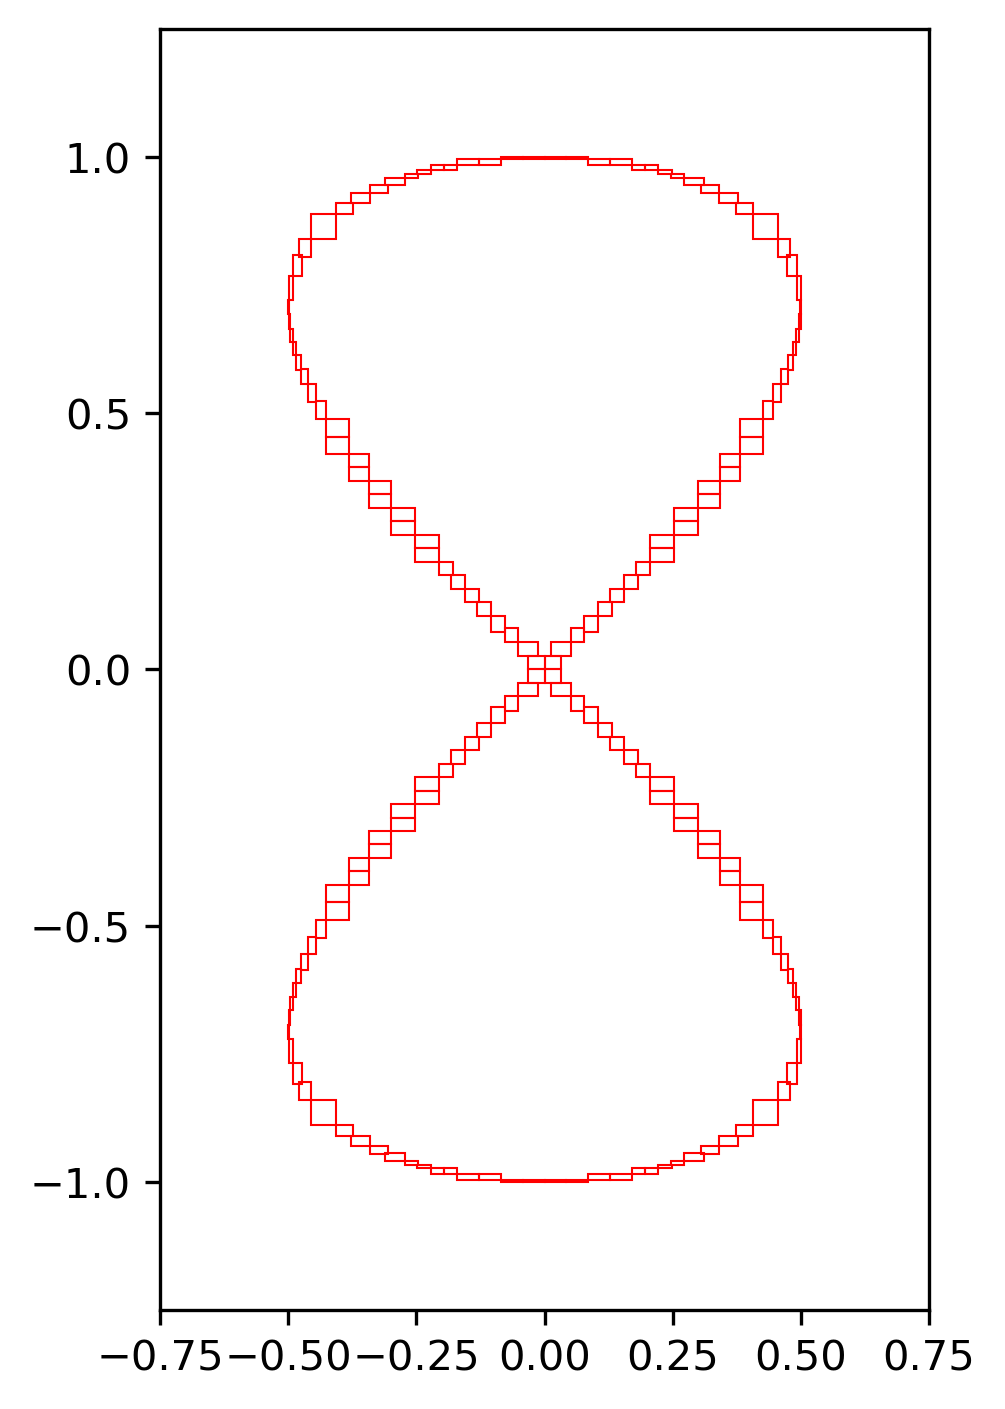

In [163]:
from matplotlib.patches import Rectangle

delta = 0.025
xrange = arange(-5.0, 20.0, delta)
yrange = arange(-5.0, 20.0, delta)
X, Y = meshgrid(xrange,yrange)

F = Y**4
G = Y**2 - X**2

fig = plt.figure(dpi=300)
# plt.contour(X, Y, (F - G), [0])
ax = plt.gca()
# ax = fig.axes[0]

for b in sols_8:#[:4]:
    # print(b)
    xlb, xub = b[0,0], b[0,1]
    ylb, yub = b[1,0], b[1,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='r',facecolor='none'))

plt.xlim([-0.75,0.75])
plt.ylim([-1.25,1.25])
# plt.xlim([-.2,.2])
# plt.ylim([-.2,.2])

ax.set_aspect(1)
plt.tight_layout()

plt.show()

In [11]:
xb = np.array([-5.,10.])
yb = np.array([-5.,10.])

#y=xy-x**2
#y-xy+x**2 = 0
#[x,y,b,p]

B = np.asarray([xb,yb,mul_intervals(xb,yb),pow_interval(xb,2)])

A_eq = np.array([[0,1,-1,1]]) #колво равенств (строки)
b_eq = np.array([0]) # правые части равенств

sqr_pairs = [(0,3)]
cross_triplets = [(0,1,2)]


# threshold_s = np.array([0.05, 0.05, 1, 1, 1])
# threshold_s = [0.1, 0.1, 1, 1, 1]

sols = approximate_boxes(B, A_eq, b_eq, sqr_pairs, cross_triplets, [1.,1.,4.,4.])

# for s in sols:
#     print(s)
print(len(sols))

lenP 1
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 2
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 3
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 4
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 5
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 6
valid indexes [0 1 2 3]
lenP 5
valid indexes [0 1 2 3]
lenP 4
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 5
valid indexes [0 1 2 3]
lenP 4
valid indexes [0 1 2 3]
lenP 3
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 4
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 5
valid indexes [0 1 2 3]
lenP 4
valid indexes [0 1 2 3]
lenP 3
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 4
valid indexes [0 1 2 3]
lenP 3
valid indexes [0 1 2 3]
lenP 2
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
valid indexes [0 1 2 3]
lenP 3
valid indexes [0 1 2 3]
val

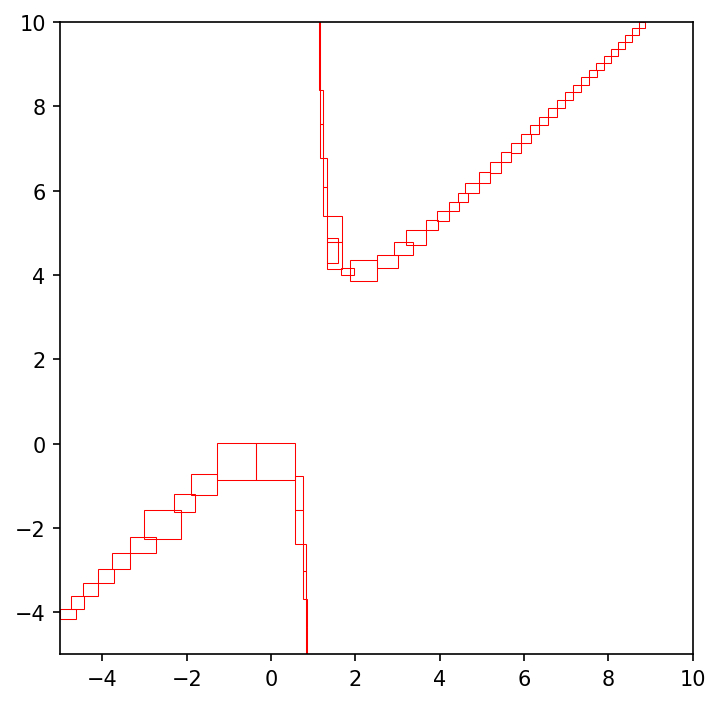

In [12]:
delta = 0.025
xrange = arange(-5.0, 20.0, delta)
yrange = arange(-5.0, 20.0, delta)
X, Y = meshgrid(xrange,yrange)

xl = np.array([-5,10])
yl = np.array([-5,10])


F = Y
G = X*Y - X**2

fig = plt.figure(dpi=150)
# plt.contour(X, Y, (F - G), [0])
ax = plt.gca()

for b in sols:
    # print(b)
    xlb, xub = b[0,0], b[0,1]
    ylb, yub = b[1,0], b[1,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='r',facecolor='none'))

plt.xlim(xl)
plt.ylim(yl)
# # plt.xlim([-.2,.2])
# # plt.ylim([-.2,.2])

ax.set_aspect(1)
plt.tight_layout()

plt.show()

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt

def cuboid_data2(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data2(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6), **kwargs)
    

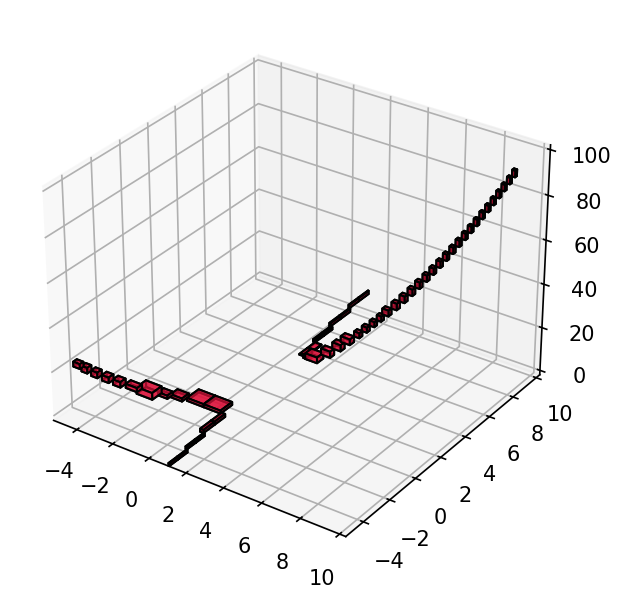

In [14]:



# positions = [(-3,5,-2),(1,7,1)]
# sizes = [(4,5,3), (3,3,7)]

inp = sols
# inp = [np.array([(0,2),(1,3),(-1,2)])]

positions = np.zeros((len(inp),3)) #[(0,0,0)]
sizes = np.zeros((len(inp),3)) #[(1,1,1)]

z_ind = 2

for i,b in enumerate(inp):
    # print(b)
    xlb, xub = b[0,0], b[0,1]
    ylb, yub = b[1,0], b[1,1]
    zlb, zub = b[z_ind,0], b[z_ind,1]
    # print(b[z_ind,:])
    positions[i,:] = xlb, ylb, zlb
    sizes[i,:] = xub-xlb, yub-ylb, zub-zlb

colors = ["crimson"]*len(inp) #,"limegreen" "crimson"
# colors = [[1.,0.,0.,1.0],[0.,1.,0.,1.]]


pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor='k', alpha=0.7)

plt.figure(dpi=150)
plt.subplot(111,projection='3d')
ax = plt.gca()
ax.add_collection3d(pc)
 
ax.set_xlim([-5,10])
ax.set_ylim([-5,10])
# ax.set_zlim([-50,100])
ax.set_zlim([0,100])

# ax.set_aspect('equal')

ax.view_init(elev=30., azim=-55)

# for ii in xrange(0,360,1):
#     ax.view_init(elev=10., azim=ii)
#     savefig("movie%d.png" % ii)

plt.show()

In [13]:
import collections
import time
from functools import partial
from scipy.optimize import linprog
from multiprocessing import Pool, freeze_support, Manager, cpu_count

from dd import process_box

# def process_box(B_c, A_eq, b_eq, 
#                 sqr_pairs=[], cross_triplets=[], 
#                 threshold_s=[0.1], threshold_v=0.95):
    
#     is_sigma_simple = len(threshold_s) == 1
#     n = A_eq.shape[1]
#     # if len(P) == 0:
#     #     return
#     # try:
#     #     B_c = P.pop() #0
#     # except(IndexError):
#     #     return
    
#     # print('B',B_c)
#     # print(P)

#     # print(B)
#     # A_ub = np.zeros((3*len(sqr_pairs), n))
#     # b_ub = np.zeros(3*len(sqr_pairs))
#     A_ub = np.full((3*len(sqr_pairs)+4*len(cross_triplets), n),None)
#     b_ub = np.full(3*len(sqr_pairs)+4*len(cross_triplets),None)

#     # Blist = [(B[i,0],B[i,1]) for i in range(n)]
#     # print(Blist)
#     # c = np.zeros(n)
#     # c[0] = 1
#     # minim = linprog(c,A_eq=A_eq,b_eq=b_eq,bounds=B)
#     # print(minim.fun)
#     # print(f'suc{minim.success}, stat{minim.status}, nit{minim.nit}\nmsg: {minim.message}')

#     # minim = linprog(-c,A_eq=A_eq,b_eq=b_eq,bounds=B)
#     # print(-minim.fun)
#     # print(f'suc{minim.success}, stat{minim.status}, nit{minim.nit}\nmsg: {minim.message}')


#     lengths_c = B_c[:,1] - B_c[:,0]
#     # valid_inds = (lengths_c > 0).nonzero()
#     # print('valind',valid_inds)
#     # print('valleng',lengths_c[valid_inds])
    
#     is_empty = False
#     is_shrinkable = True
#     if is_sigma_simple:
#         is_small_enough = np.max(lengths_c) <= threshold_s[0]
#     else:
#         is_small_enough = (lengths_c <= threshold_s).all()
    
#     while not is_empty and is_shrinkable and not is_small_enough:  #uncomment for better timings
#         lengths_p = lengths_c
#         # valid_inds_p = np.transpose((lengths_p > 0).nonzero())
#         valid_inds_p = (lengths_p > 0).nonzero()[0]

#         #shrink
#         for i in valid_inds_p: #range(n):
#             c = np.zeros(n)
#             c[i] = 1

#             #inequalities for current bounds
#             shift = 0
#             for j, (m_ind, p_ind) in enumerate(sqr_pairs):
#                 A, b = calc_parab_ineq(B_c[m_ind,:], m_ind, p_ind, n)
#                 A_ub[3*j:3*j+3,:] = A
#                 b_ub[3*j:3*j+3] = b
#                 shift += 3
#             for j, (m_ind, n_ind, p_ind) in enumerate(cross_triplets):
#                 A, b = calc_hyberb_ineq(B_c[m_ind,:], B_c[n_ind,:], m_ind, n_ind, p_ind, n)
#                 A_ub[4*j+shift:4*j+4+shift,:] = A
#                 b_ub[4*j+shift:4*j+4+shift] = b

#             minim = linprog(c,A_eq=A_eq,b_eq=b_eq,bounds=B_c, A_ub=A_ub, b_ub=b_ub,options={'presolve':False}) #method='highs-ipm' #slower but more boxes with presolve 
#             if not minim.success:
#                 is_empty = True
#                 print(minim.message)
#                 # if minim.status != 2:
#                 #     print(minim.message)
#                 break

#             B_c[i,0] = minim.fun

#             #comment for better timings
#             #inequalities for updated bounds
#             shift = 0
#             for j, (m_ind, p_ind) in enumerate(sqr_pairs):
#                 A, b = calc_parab_ineq(B_c[m_ind,:], m_ind, p_ind, n)
#                 A_ub[3*j:3*j+3,:] = A
#                 b_ub[3*j:3*j+3] = b
#                 shift += 3
#             for j, (m_ind, n_ind, p_ind) in enumerate(cross_triplets):
#                 A, b = calc_hyberb_ineq(B_c[m_ind,:], B_c[n_ind,:], m_ind, n_ind, p_ind, n)
#                 A_ub[4*j+shift:4*j+4+shift,:] = A
#                 b_ub[4*j+shift:4*j+4+shift] = b

#             maxim = linprog(-c,A_eq=A_eq,b_eq=b_eq,bounds=B_c, A_ub=A_ub, b_ub=b_ub,options={'presolve':False}) #method='highs-ipm'
#             if not maxim.success:
#                 is_empty = True
#                 print(maxim.message)
#                 # if maxim.status != 2:
#                 #     print(maxim.message)
#                 break

#             # B_c[i,0] = minim.fun
#             B_c[i,1] = -maxim.fun

#             # if is_small_enough: #worse than without checking, but better time
#             #     break

#         lengths_c = B_c[:,1] - B_c[:,0]
#         longest_dim_ind = np.argmax(lengths_c)
#         if is_sigma_simple:
#             is_small_enough = lengths_c[longest_dim_ind] <= threshold_s[0]
#         else:
#             is_small_enough = (lengths_c <= threshold_s).all()

#         valid_inds = (lengths_c > 0).nonzero()
#         print('valid indexes',valid_inds[0])
#         # print('valleng',lengths_c[valid_inds])
#         V_p = np.prod(lengths_p[valid_inds])
#         V_c = np.prod(lengths_c[valid_inds])
        
#         # print(V_c,V_p)
#         is_shrinkable = V_c/V_p <= threshold_v
#         # print(is_shrinkable)

#     if not is_empty:
#         if is_small_enough:
#             return (1,B_c)
#             # sols.append(B_c)
#         else:
#             #split
#             half_length = lengths_c[longest_dim_ind]/2.
#             B1 = B_c.copy()
#             B1[longest_dim_ind,1] -= half_length
#             B2 = B_c.copy()
#             B2[longest_dim_ind,0] += half_length
#             return (2,B1,B2)
#             # P.append(B1)
#             # P.append(B2)
#     return (0,)

# def append_split(res, P):
#     if res is not None:
#         P.append(res[0])
#         P.append(res[1])
#         print('aloha')

# def approximate_boxes_parallel(B, A_eq, b_eq, 
#                                sqr_pairs=[], cross_triplets=[], 
#                                threshold_s=[0.1], threshold_v=0.95):
#     timeout = 10
#     queue_cap = 16
#     n_processes = 2

#     n = np.shape(B)[0]
#     # sols = []
#     # P = [B]

#     freeze_support()
#     manager=Manager()
#     pool = Pool(n_processes)
#     sharedP=manager.list()
#     sharedP.append(B)
#     # print('B',B)
#     # print(sharedP)
#     sharedsols=manager.list()

#     # print(sharedP)
#     print('-------------------')
#     process_box_ = partial(process_box, sols=sharedsols, n=n, 
#                            A_eq=A_eq, b_eq=b_eq, 
#                            sqr_pairs=sqr_pairs, cross_triplets=cross_triplets, 
#                            threshold_s=threshold_s, threshold_v=threshold_v)
#     # append_split_ = partial(append_split, P=sharedP)

#     t0 = time.time()
#     q = collections.deque()
#     while True:
#         # while len(sharedP) > 0 and len(sharedP)<5:
#         print(f'lenP {len(sharedP)}')
#         # mB_c = []
#         # slicer = 0
#         # while len(sharedP) > 0 and slicer<3:
#         #     mB_c.append(sharedP.pop())
#         #     slicer += 1
#             # B_c = sharedP.pop() #0
#         # print('mB len',len(mB_c))
#         batch = 4
#         mapres = pool.map(process_box_,sharedP[:np.min((len(sharedP),batch))])
#         if mapres:
#             print(mapres)
#             for r in mapres:
#                 if r is not None:
#                     sharedP.append(r[0])
#                     sharedP.append(r[1])
#                     print('aloha')
#                     print('shP',len(sharedP))
#         else:
#             break
    

#         # q.append(pool.apply_async(process_box_, (B_c,))) # MUST USE (arg,), but callback isnt necessary , callback=log_solution
#         # if len(q) >= queue_cap:
#         #     res = q.popleft().get(timeout=timeout)
#         #     if res is not None:
#         #         sharedP.append(res[0])
#         #         sharedP.append(res[1])
#         #         print('aloha')
#         # while len(q):
#         #     print('lq',len(q))
#         #     res=q.popleft().get(timeout=timeout)
#         #     if res is not None:
#         #         sharedP.append(res[0])
#         #         sharedP.append(res[1])
#         #         print('aloha2')
#         # if len(sharedP) < 1:
#         #     break
#     pool.close()
#     pool.join()
#     print('Finished at',time.time()-t0)

#     print('-------------------')
#     # print(sharedP)
#     # print(sharedsols)

#     return sharedsols

def box_serial(boxes, A_eq, b_eq, 
                 sqr_pairs=[], cross_triplets=[], 
                 threshold_s=[0.1], threshold_v=0.95):
    P = collections.deque(boxes)
    sols = []

    print('-------------------') 
    process_box_ = partial(process_box, A_eq=A_eq, b_eq=b_eq, 
                           sqr_pairs=sqr_pairs, cross_triplets=cross_triplets, 
                           threshold_s=threshold_s, threshold_v=threshold_v)
    t2 = time.time()

    while len(P) > 0:
        print('unexplored:',len(P))
        B_c = P.popleft()

        r = process_box_(B_c)

        # result.extend(g2)
        if r[0] == 0:
            pass
        elif r[0] == 1:
            sols.append(r[1])
            # print('sol')
        else:
            P.append(r[1])
            P.append(r[2])
            # print('split')    

    print(f'Search took {time.time()-t2:.3f} seconds')

    print('-------------------')
    # print(sharedP)
    # print(len(sharedP))
    # print(sharedsols)
    print('unexplored:',len(P))
    print('solutions:',len(sols))
    return sols

def box_parallel(boxes, A_eq, b_eq, 
                 sqr_pairs=[], cross_triplets=[], 
                 threshold_s=[0.1], threshold_v=0.95,
                 n_processes=2,batch=256):
    freeze_support()

    # n_processes = cpu_count()//2
    pool = Pool(n_processes)
    # with Pool(4) as pool: #cpu_count()
    P = collections.deque(boxes)
    sols = []
    print('-------------------')
    process_box_ = partial(process_box, A_eq=A_eq, b_eq=b_eq, 
                           sqr_pairs=sqr_pairs, cross_triplets=cross_triplets, 
                           threshold_s=threshold_s, threshold_v=threshold_v)
    t2 = time.time()

    # batch = 128*n_processes
    while True:
        print('unexplored:',len(P))
        mapres = pool.map(process_box_, [P.popleft() for _ in range(np.min((batch,len(P))))])
        if mapres:
            for r in mapres:
                # result.extend(g2)
                if r[0] == 0:
                    pass
                elif r[0] == 1:
                    sols.append(r[1])
                    # print('sol')
                else:
                    P.append(r[1])
                    P.append(r[2])
                    # print('split')
            # time.sleep(1)
        else:
            break

    pool.close()
    pool.join()
    print(f'Search took {time.time()-t2:.3f} seconds')

    print('-------------------')
    print('unexplored:',len(P))
    print('solutions:',len(sols))
    return sols

In [40]:


xb = np.array([-5.,10.])
yb = np.array([-5.,10.])

#y=xy-x**2
#y-xy+x**2 = 0
#[x,y,b,p]

B = np.asarray([xb,yb,mul_intervals(xb,yb),pow_interval(xb,2)])

A_eq = np.array([[0,1,-1,1]]) #колво равенств (строки)
b_eq = np.array([0]) # правые части равенств

sqr_pairs = [(0,3)]
cross_triplets = [(0,1,2)]

P = [B]
# threshold_s = np.array([0.05, 0.05, 1, 1, 1])
# threshold_s = [0.1, 0.1, 1, 1, 1]

# sols = box_serial(P, A_eq, b_eq, sqr_pairs, cross_triplets, [0.04,0.04,4.,4.])
sols = box_parallel(P, A_eq, b_eq, sqr_pairs, cross_triplets, [0.04,0.04,4.,4.],
                    n_processes=4,batch=10096)

# sols = approximate_boxes(B, A_eq, b_eq, sqr_pairs, cross_triplets, [0.04,0.04,4.,4.])

# for s in sols:
#     print(s)

-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 128
unexplored: 242
unexplored: 156
unexplored: 162
unexplored: 296
unexplored: 322
unexplored: 140
unexplored: 172
unexplored: 80
unexplored: 0
Search took 23.898 seconds
-------------------
unexplored: 0
solutions: 913


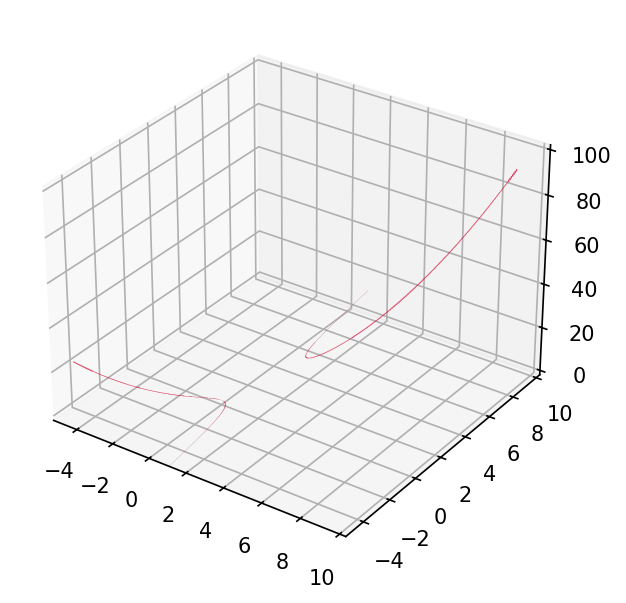

In [41]:
inp = sols
# inp = [np.array([(0,2),(1,3),(-1,2)])]

positions = np.zeros((len(inp),3)) #[(0,0,0)]
sizes = np.zeros((len(inp),3)) #[(1,1,1)]

z_ind = 2

for i,b in enumerate(inp):
    # print(b)
    xlb, xub = b[0,0], b[0,1]
    ylb, yub = b[1,0], b[1,1]
    zlb, zub = b[z_ind,0], b[z_ind,1]
    # print(b[z_ind,:])
    positions[i,:] = xlb, ylb, zlb
    sizes[i,:] = xub-xlb, yub-ylb, zub-zlb

colors = ["crimson"]*len(inp) #,"limegreen" "crimson"
# colors = [[1.,0.,0.,1.0],[0.,1.,0.,1.]]


pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor=None, alpha=0.7)

plt.figure(dpi=150)
plt.subplot(111,projection='3d')
ax = plt.gca()
ax.add_collection3d(pc)
 
ax.set_xlim([-5,10])
ax.set_ylim([-5,10])
# ax.set_zlim([-50,100])
ax.set_zlim([0,100])

# ax.set_aspect('equal')

ax.view_init(elev=30., azim=-55)

# for ii in xrange(0,360,1):
#     ax.view_init(elev=10., azim=ii)
#     savefig("movie%d.png" % ii)

plt.show()

Использование алгоритма для двузвенника

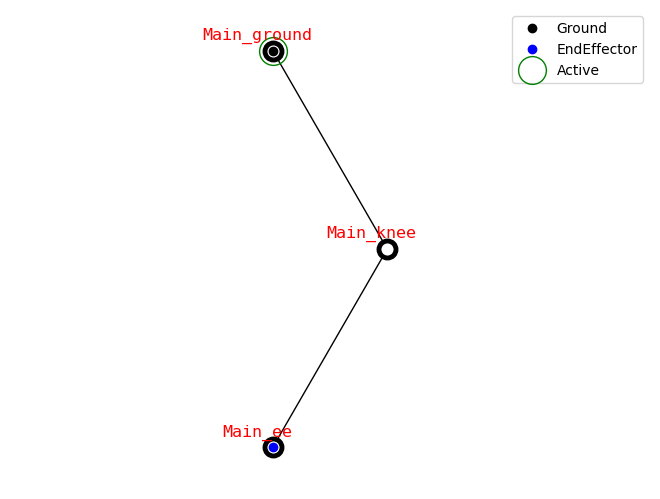

In [12]:
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
from auto_robot_design.description.utils import draw_joint_point

gen = TwoLinkGenerator()
gen.build_standard_two_linker()
graph = gen.graph

draw_joint_point(graph)

In [13]:
from auto_robot_design.description.mechanism import JointPoint2KinematicGraph
from auto_robot_design.description.utils import draw_links

kinematic_graph = JointPoint2KinematicGraph(graph)
# draw_links(kinematic_graph, graph)
from auto_robot_design.description.utils import draw_kinematic_graph
# draw_kinematic_graph(kinematic_graph)
main_branch = kinematic_graph.define_main_branch()
# draw_kinematic_graph(main_branch)
kin_tree = kinematic_graph.define_span_tree()
# draw_kinematic_graph(kin_tree)

L3 (array([[-0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       , -0.8660254]]), array([0., 0., 0.]))
G (array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([0., 0., 0.]))
L4 (array([[-0.8660254, -0.       , -0.5      ],
       [ 0.       ,  1.       , -0.       ],
       [ 0.5      ,  0.       , -0.8660254]]), array([ 0.28867513,  0.        , -0.5       ]))
EE (array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([ 0.,  0., -1.]))


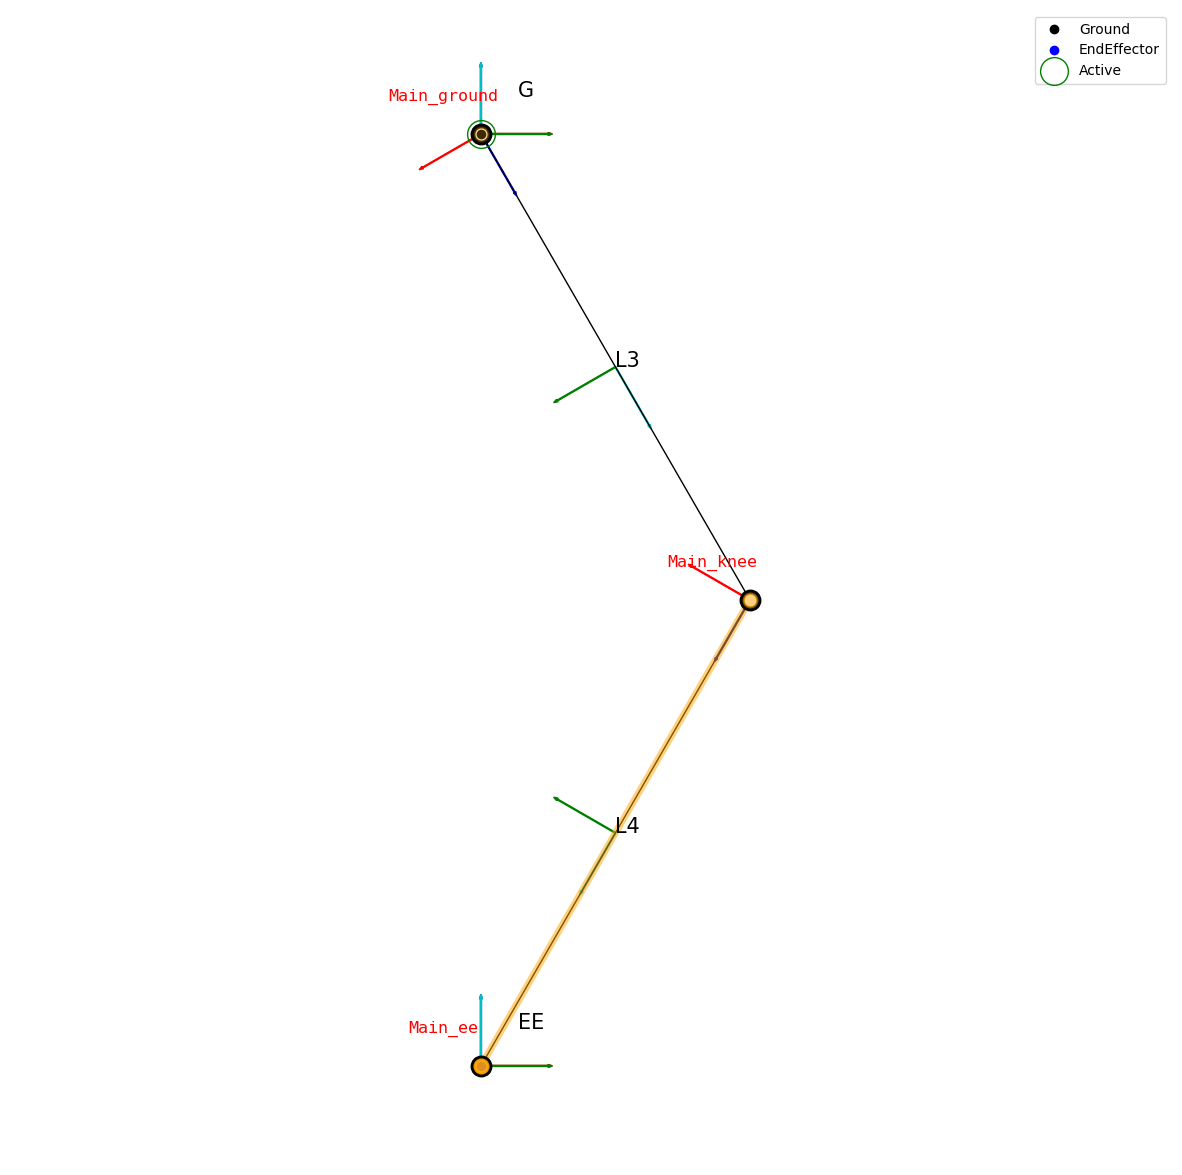

In [44]:
import modern_robotics as mr
from auto_robot_design.description.utils import draw_link_frames
from auto_robot_design.description.actuators import TMotor_AK80_9

thickness = 0.04
density = 2700 / 2.8

for n in kinematic_graph.nodes():
    n.thickness = thickness
    n.density = density

for j in kinematic_graph.joint_graph.nodes():
    j.pos_limits = (-np.pi, np.pi)
    if j.jp.active:
        j.actuator = TMotor_AK80_9()
    j.damphing_friction = (0.05, 0)
    
kinematic_graph.define_link_frames()
for l in kinematic_graph.nodes():
    print(l.name, mr.TransToRp(l.frame))
    # print(next(iter(l.joints)).jp.r)

draw_link_frames(kinematic_graph)
draw_links(kinematic_graph, graph)

In [153]:
# rxb = np.array([-1.5,1.5])
# ryb = np.array([-1.5,0.])

rxb = np.array([-1.5,1.5])
ryb = np.array([-1.5,0.])

un_b = np.array([-1., 1.])

# for each i joint
# rj+Rj pij = rk+Rk pik
#by components 
# rj1 + cj pi1j - sj pi2j = rk1 + ck pi1k - sk pi2k
# rj2 + sj pi1j + cj pi2j = rk2 + sk pi1k + ck pi2k

# for each link 
# R is valid so
# c2 + s2 = 1
# c2 = c**2
# s2 = s**2

# X: [rj1, rj2, cj, sj, cj2, sj2, ...]
#n_j=2 long equations 
#n_l=2 parameters count
# links_reduced = {kinematic_graph.nodes()} - {kinematic_graph.EE, kinematic_graph.G}
links = {n.name: n for n,d in kinematic_graph.nodes(data=True)}
js1 = list(links['L3'].joints)
js2 = list(links['L4'].joints)
rb_j = np.full((len(links)-1,2,2),None) #links-ee
#TODO add smart filling of rb_j
rb_j[0,0,:] = np.zeros(2)
rb_j[0,1,:] = np.zeros(2)
rb_j[1,0,:] = rxb
rb_j[1,1,:] = ryb
rb_j[2,0,:] = rxb
rb_j[2,1,:] = ryb

# print(js2)

#p1 expressed in 0 frame
p1x0, p1y0 = 0., 0.

p1x1, p1y1 = 0., -np.linalg.norm(js1[0].jp.r-js1[1].jp.r) #TODO check if there are only 2
p2x1, p2y1 = 0., 0.

p2x2, p2y2 = 0., -np.linalg.norm(js2[0].jp.r-js2[1].jp.r)

eex2, eey2 = 0., 0

# p1x1, p1y1 = 0., 0.
# p2x1, p2y1 = 0., np.linalg.norm(js1[0].jp.r-js1[1].jp.r) #TODO check if there are only 2

# p2x2, p2y2 = 0., 0.

# eex2, eey2 = 0., np.linalg.norm(js2[0].jp.r-js2[1].jp.r)

p_i = np.full((len(links)-1,2+1,2),None) #links-ee, joints +ee, ncoords
# p_i[0,0,:] = [p1x0,p1y0]
p_i[1,0,:] = [p1x1,p1y1]
p_i[1,1,:] = [p2x1,p2y1]
p_i[2,1,:] = [p2x2,p2y2]
p_i[2,2,:] = [eex2,eey2]

B = np.asarray([rxb,ryb,un_b,un_b,pow_interval(un_b,2),pow_interval(un_b,2),
                rxb,ryb,un_b,un_b,pow_interval(un_b,2),pow_interval(un_b,2),
                rxb,ryb]) #ee coords

A_eq = np.array([[1,0,p1x1,-p1y1,0,0, #1 joint
                  0,0,0,0,0,0, 0,0],
                  [0,1,p1y1,p1x1,0,0,
                  0,0,0,0,0,0, 0,0],
                  [1,0,p2x1,-p2y1,0,0, #2 joint
                  -1,0,-p2x2,p2y2,0,0, 0,0],
                  [0,1,p2y1,p2x1,0,0,
                  0,-1,-p2y2,-p2x2,0,0, 0,0],
                  [0,0,0,0,1,1, #link 1 trig
                   0,0,0,0,0,0, 0,0], 
                   [0,0,0,0,0,0, #link 2 trig
                   0,0,0,0,1,1, 0,0],
                  [0,0,0,0,0,0, # ee
                   1,0,eex2,-eey2,0,0, -1,0],
                  [0,0,0,0,0,0,
                   0,1,eey2,eex2,0,0, 0,-1]])
b_eq = np.array([p1x0,p1y0,0,0,1,1, 
                 0,0]) # правые части равенств

# for every independent loop we equalize sum of twists before and after some link
# if loops have common links, we pick first link where they merge to 1 loop
# wj Sj + ... = wk Sk + ...
#sum of twists from ground to EE (T's components are first variables in m where L m=0)   
# T = wj Sj + ...  
# expanded 
# vx = wj sjx + ...
# vy = wj sjy + ...
# w = wj 1 + ...

# m: [vx,vy,w,wi...]
# ms: [vxs,vys,ws,wis...]
# Sj = [sjx,sjy,1] (so omit 1 from vars: [sjx,sjy])   sjx=Pjy sjy=-Pjx (global coords of j-th joint)
# fj = [fjx, fjy]   fjx = sjx wj, fjy = sjy wj

# new X: [m, ms, Sj..., fj,...]

# T path (joints): 1,2
#X: [vx,vy,w,w1,w2, 
#    vxs,vys,ws,w1s,w2s, 
#    s1x,s1y, s2x,s2y,
#    f1x,f1y, f2x,f2y]

# m: [vx,vy,w,wact,wpas...]
# mv: [wact...]
# my: [vx,vy,w,wpas...]

# mu: [vx,vy]  mb with w
# mz: [w,wact,wpas...]
nj = 2
n_mob = 2
n_loops = 0
shift = A_eq.shape[1]
q_act_inds = [0,1]  # in q
out_inds = [0,1,2]  # in T
mv_inds = [i+3 for i in q_act_inds]
mu_inds = out_inds

inds_2remove = mu_inds.copy() #TODO input here, and set flag
n_eps = n_mob+nj - 2#len(inds_2remove)
inds_2remove.extend([i+3+nj for i in mu_inds])
# rhs = np.zeros(3+3*n_loops)
rhs = np.zeros(2) #TODO make smart

B2 = np.zeros((2*n_eps+4*nj,2))

#TODO try updating bounds with pow and mul during computation
# (shift+(3-len(out_inds))+ i, shift+2*(n_eps)+ i*2, shift+2*(n_eps)+2*nj+ i*2) # sx triplet (w,sx,fx)
is_rem_out = True
if is_rem_out:
    for i in range(n_eps):
        B2[i,:] = un_b
        B2[i+n_eps,:] = pow_interval(un_b,2)
    for i in range(nj): #intervals for sx, sy and fx, fy
        for j in range(p_i.shape[0]):
            if p_i[j,i,0] is not None:
                # six = yi = rjy + cj piyj + sj pixj
                B2[2*(n_eps)+ i*2,:] = rb_j[j,1,:] + un_b*p_i[j,i,1] + un_b*p_i[j,i,0]  
                print(i, j, 'sx sum', rb_j[j,1,:], un_b*p_i[j,i,1], un_b*p_i[j,i,0])
                # siy = -xi = -rjx - cj pixj + sj piyj
                B2[2*(n_eps)+1+ i*2,:] = neg_interval(subtr_intervals((rb_j[j,0,:] + un_b*p_i[j,i,0]), un_b*p_i[j,i,1]))
                print('sy sum  -',rb_j[j,0,:],'+',un_b*p_i[j,i,0],'-',un_b*p_i[j,i,1])

                B2[2*(n_eps)+2*nj+ i*2,:] = mul_intervals(un_b, B2[2*(n_eps)+ i*2,:]) #interval w*sx
                B2[2*(n_eps)+2*nj+1+ i*2,:] = mul_intervals(un_b, B2[2*(n_eps)+1+ i*2,:]) #interval w*sy
                break

A_eqT = np.array([[1,0,0, 0,0, # vx =...
                   0,0,0, 0,0,
                   0,0,0,0,
                   -1,0,-1,0], #TODO MB we dont need '-' here and below
                  [0,1,0, 0,0, # vy =...
                   0,0,0, 0,0,
                   0,0,0,0,
                   0,-1,0,-1],
                  [0,0,1, -1,-1, # w =... 
                   0,0,0, 0,0,
                   0,0,0,0,
                   0,0,0,0]])
Lz = A_eqT.copy()
Lz = np.delete(Lz,inds_2remove,1)
### Lz = np.delete(Lz,0,1)
Lz = np.delete(Lz,2,0)
if Lz.shape[1] != n_eps*2+4*nj: #or Lz.shape[0] != nj:
    raise ValueError("height of L for non-redundant must be =nj")

A_eqS = np.array([[0,1,p1y1,p1x1,0,0, # s1x
                    0,0,0,0,0,0, 0,0,
                    0,0,0, 0,0,
                    0,0,0, 0,0,
                    -1,0,0,0,
                    0,0,0,0],
                    [-1,0,-p1x1,p1y1,0,0, # s1y
                    0,0,0,0,0,0, 0,0,
                    0,0,0, 0,0,
                    0,0,0, 0,0,
                    0,-1,0,0,
                    0,0,0,0],
                  [0,0,0,0,0,0, # s2x
                  0,1,p2y2,p2x2,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,-1,0,
                  0,0,0,0],
                  [0,0,0,0,0,0, # s2y
                  -1,0,-p2x2,p2y2,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,0, 0,0,
                  0,0,0,-1,
                  0,0,0,0]])
A_eqSz = A_eqS.copy()
A_eqSz = np.delete(A_eqSz,[i+shift for i in inds_2remove], 1)

b_eqT = rhs
# ([0-p1y0,0+p1x0, # zeros because r0 = [0,0] for any mechanism. 
# ,0,0])
b_eqS = np.array([0,0,
                  0,0])

eps_length = 1.
A_eq_eps = np.array([[0,0,0, 0,0, # vector m is not zero
                      1,1,1, 1,1,
                      0,0,0,0,
                      0,0,0,0]])
A_eq_epsz = A_eq_eps.copy()
A_eq_epsz = np.delete(A_eq_epsz,inds_2remove,1)

b_eq_eps = np.array([eps_length])

# m_length_lb = 0.01
# A_ub_m = np.array([[0,0,0, 0,0, # vector m is not zero
#                    -1,-1,-1, -1,-1,
#                    0,0,0,0,
#                    0,0,0,0]])
# b_ub_m = np.array([-m_length_lb])


# [0,0,0,0,0,0, # s1x simpler because in 0 frame
# 0,0,0,0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,0,0, 0,0,
# -1,0,0,0,
# 0,0,0,0],
# [0,0,0,0,0,0, # s1y simpler because in 0 frame
# 0,0,0,0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,0,0, 0,0,
# 0,-1,0,0,
# 0,0,0,0],

sqr_pairs = [(2,4), (3,5), #link1
             (8,10), (9,11), #link2
            #  (shift+0,shift+5),(shift+1,shift+6),(shift+2,shift+7),(shift+3,shift+8),(shift+4,shift+9) # 3+nj for full L
             ]
for i in range(n_eps):
    sqr_pairs.append((shift+i, shift+n_eps+i))

# indexes for hyperbolic terms
#wi = shift + 3 + j_ind                  (starting from 0) #works for full L and m #TODO fix for deleting wis
#six = shift + 2*(3+nj) + j_ind*nj
#siy = shift + 2*(3+nj) + j_ind*nj + 1
#fix = shift + 2*(3+nj) + 2*nj + j_ind*nj
#fiy = shift + 2*(3+nj) + 2*nj + j_ind*nj + 1

cross_triplets = []
# cross_triplets = [(shift+3+ 0, shift+2*(3+nj)+ 0*nj, shift+2*(3+nj)+2*nj+ 0*nj), #j1   w sx
#                   (shift+3+ 0, shift+2*(3+nj)+1+ 0*nj, shift+2*(3+nj)+2*nj+1+ 0*nj), # w sy
#                   (shift+3+ 1, shift+2*(3+nj)+ 1*nj, shift+2*(3+nj)+2*nj+ 1*nj), #j2   w sx
#                   (shift+3+ 1, shift+2*(3+nj)+1+ 1*nj, shift+2*(3+nj)+2*nj+1+ 1*nj), # w sy
#                   ]
if is_rem_out:
    for i in range(nj):
        cross_triplets.append((shift+ i, shift+2*(n_eps)+ i*2, shift+2*(n_eps)+2*nj+ i*2))
        cross_triplets.append((shift+ i, shift+2*(n_eps)+1+ i*2, shift+2*(n_eps)+2*nj+1+ i*2))
# print(A_eq)

for i in range(4,12):
    B2[i,:] = np.array([-1.5,1.5])
B_merg = np.vstack((B,B2))
A_eq_merg = np.vstack((np.hstack((A_eq, np.zeros((A_eq.shape[0],Lz.shape[1])))),
                       np.hstack((np.zeros((Lz.shape[0],shift)),Lz)),
                       A_eqSz,
                       np.hstack((np.zeros((A_eq_epsz.shape[0],shift)),A_eq_epsz))
                       ))
# print(Lz)
# print(A_eq_epsz)
# print(cross_triplets)
# print(sqr_pairs)
# print(A_eq_epsz)
b_eq_merg = np.concatenate((b_eq,b_eqT,b_eqS,b_eq_eps))

print(B)

0 1 sx sum [-1.5 0.0] [ 0.57735027 -0.57735027] [-0.  0.]
sy sum  - [-1.5 1.5] + [-0.  0.] - [ 0.57735027 -0.57735027]
1 1 sx sum [-1.5 0.0] [-0.  0.] [-0.  0.]
sy sum  - [-1.5 1.5] + [-0.  0.] - [-0.  0.]
[[-1.5  1.5]
 [-1.5  0. ]
 [-1.   1. ]
 [-1.   1. ]
 [ 0.   1. ]
 [ 0.   1. ]
 [-1.5  1.5]
 [-1.5  0. ]
 [-1.   1. ]
 [-1.   1. ]
 [ 0.   1. ]
 [ 0.   1. ]
 [-1.5  1.5]
 [-1.5  0. ]]


In [144]:
threshold_s = [0.2, 0.2, 2, 2, 2, 2,
               0.2, 0.2, 2, 2, 2, 2,
               0.2, 0.2,
               1,1,
               1,1,
               4,4,4,4,
               4,4,4,4]
# threshold_s = [0.5]

# sols = approximate_boxes(B, A_eq, b_eq, sqr_pairs, cross_triplets, threshold_s)
sols = approximate_boxes(B_merg, A_eq_merg, b_eq_merg, sqr_pairs, cross_triplets, threshold_s)

# for s in sols:
#     print(s)
print(len(sols))

lenP 1
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
lenP 2
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
lenP 3
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
lenP 4
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
lenP 5
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
lenP 6
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25]
valid indexes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21 22 

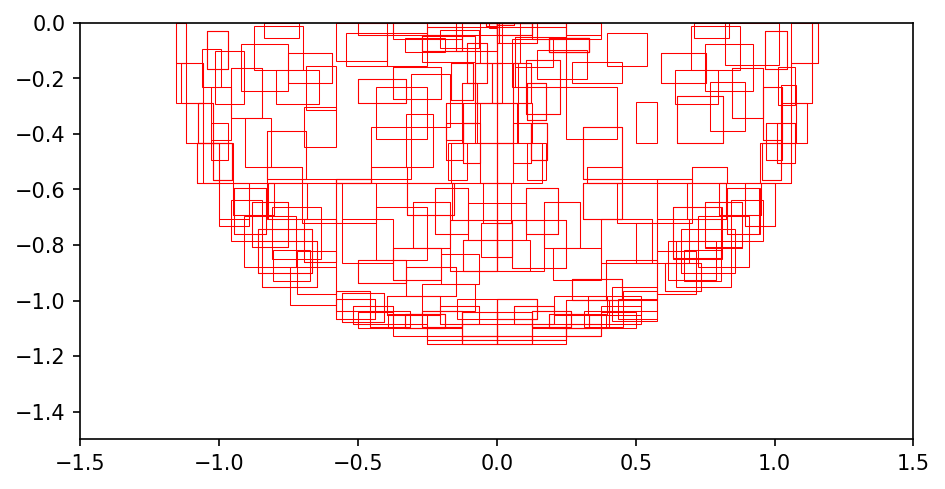

In [158]:
xl = np.array([-1.5,1.5])
yl = np.array([-1.5,0.])

fig = plt.figure(dpi=150)
ax = plt.gca()

#TODO ПОМНИМ ЧТО БЫВАЕТ НАХОДИТ РЕШЕНИЯ В КОРОБКЕ С некоторыми НУЛЕВЫМИ СТОРОНАМИ
x_ind = 12
y_ind = 13

for b in sols[::30]:
    # print(b)
    xlb, xub = b[x_ind,0], b[x_ind,1]
    ylb, yub = b[y_ind,0], b[y_ind,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='r',facecolor='none'))

plt.xlim(xl)
plt.ylim(yl)

ax.set_aspect(1)
plt.tight_layout()

plt.show()